This code demonstrates the 'calibration' of NMR data using slug tests from boreholes. The slug tests are used to estimate the K at the screened interval of the bores and we use these K values to estimate an optimal constant for the two equations.

Neil Symington

neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
from sqlite3 import dbapi2 as sqlite
import pandas as pd
import fiona
from shapely.geometry import Polygon, shape
from shapely import wkt
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils, SNMR_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import matplotlib.pyplot as plt
import os
import math
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import rasterio
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
from hydrogeol_utils.db_utils import makeCon, closeCon

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def resample_categorical_intervals(df, parameter_columns,
                                   interval_columns, new_intervals):
    # If the parameter input is a string and not a list make it a list
    if isinstance(parameter_columns, ("".__class__, u"".__class__)):
        parameter_columns = [parameter_columns]
    
    # Create a dataframe to add to
    df_resampled = pd.DataFrame(columns = interval_columns, data = new_intervals)
    
    for p in parameter_columns:
        
        df_resampled[p] = ''
        
        # Iterate through the new intervals
        for i, interval in enumerate(new_intervals):
            
            new_depth_from = interval[0]
            new_depth_to = interval[1]

            mask = (df[interval_columns[0]] < new_depth_to) & (df[interval_columns[1]] > new_depth_from)
            
            v = df[mask][p].mode()
            
            if len(v) == 1:
                
                df_resampled.at[i, p] = v.values[0]
            
            elif len(v) > 1:

                df_resampled.at[i, p] = 'transition'
    
    return df_resampled

In [4]:
# This function extracts the K profile using the SDR equation

def SDR_K(df, N = 1, C = 4000):
    '''
    df: dataframe containing GMR inversion data
    N: empirical exponent for water content when estimating the water content
    C: empirical constant for estimating water content
    '''
    return C * df['Total_water_content'].values * df['T2*'].values
    #return C * np.power(df['Total_water_content'].values, N) * np.square(df['T2'].values)

def TC_K(df, N = 2, C=4000):
    """
    Function for calculating hydraulic conductivity using the TC equation

    :param mobile_water_content: flat array with mobile water content
    values
    :param total_water_content: flat array with total water content
    values
    :param N: empirical exponent for water content when estimating
     the water content
    :param C: empirical constant for estimating water content
    :return:
    hydraulic conductivity profile as array
    """

    return C * np.power(df['Total_water_content'], N) * np.divide(
        np.power(df['Total_water_content'], N),
        np.subtract(np.power(df['Total_water_content'], N),
                    np.power(df['Mobile_water_content'], N)))

def objective_function(df, C, N, equation= 'SDR', loss_fn = 'L2'):
    if equation == 'SDR':
        # Find an estimate of log10 K
        df['SNMR_K'] = SDR_K(df, N = N, C = C)
    if equation == 'TC':
        # Find an estimate of log10 K
        df['SNMR_K'] = TC_K(df, N = N, C = C)
    # Retrun the sum of the squares
    if loss_fn == 'L2':
        return ((df['SNMR_K'] - df['K'])**2).sum()
    if loss_fn == 'L1':
        return (np.abs(df['SNMR_K'] - df['K'])).sum()
    


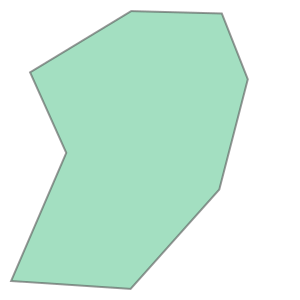

In [5]:
# Clip the df_acquisitions to the Ord Keep polygon

# Open geometry for a shapefile. This will be used to filter the bores extracted from the database
c = fiona.open(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\Keep_spatial\Keep_River_polygons.shp")
collection = [ shape(item['geometry']) for item in c ]
names = [item['properties']['Name'] for item in c]
polygons = [Polygon(pol.exterior.coords) for pol in collection] 

# Display
OrdKeep = polygons[names.index('DENR_model_outline')]
#OrdKeep = polygons[names.index('water_table_clip')]

OrdKeep

In [6]:
# First import the slug test data

infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\slug_test\compiledSlugtestResults_Keep.xlsx"

df_slugs = pd.read_excel(infile)

In [24]:
# In lieau of a better approach we will average the log of the hydraulic conductivity for each
# bore

df_slugs['log_K'] = np.log10(df_slugs['K estimate (m/day)'].values)

df_logK = df_slugs.groupby(['borehole_id']).min()[['log_K']]



In [25]:
# Now we want to know the screened interval and other spatial information so we open up the 
# borehole database

path = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite"

DB_PATH = os.path.join(path, "East_Kimberley_borehole_data.sqlite")

SPATIALITE_PATH = r'C:\mod_spatialite-4.3.0a-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = makeCon(DB_PATH)

Connected to \\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite\East_Kimberley_borehole_data.sqlite. Temporary working copy created.


In [26]:
cols = ['Easting','Northing', 'Borehole_name', 'alternative_name', 'Ground_elevation_mAHD', 'borehole_id']

df_header = borehole_utils.extract_sql_with_primary_key("borehole", cols,  connection, df_logK.index,
                                                        verbose = True)
cols = ['Depth_from','Depth_to', 'Construction_name', 'borehole_id']

df_construction = borehole_utils.extract_sql_with_primary_key('borehole_construction', cols, connection, df_logK.index,
                                                        verbose = True)
# Only keep the screened interval

df_construction = df_construction[df_construction['Construction_name'] == 'screen']

df_merged = df_logK.merge(df_header, on = 'borehole_id').merge(df_construction, on = 'borehole_id')


select t.Easting, t.Northing, t.Borehole_name, t.alternative_name, t.Ground_elevation_mAHD, t.borehole_id from borehole t where t.borehole_id in (635728,635732,635733,635734,635735,635736,635737,635738,635739,635740,635741,635742,635743,635745,635921);
select t.Depth_from, t.Depth_to, t.Construction_name, t.borehole_id from borehole_construction t where t.borehole_id in (635728,635732,635733,635734,635735,635736,635737,635738,635739,635740,635741,635742,635743,635745,635921);


In [27]:
# Now we want to find the stratigraphy at each hole

infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\stratigraphy\EK_SonicStratigraphySummary.csv"

df_interp = pd.read_csv(infile)

# Add a stratigraphy column
df_merged['stratigraphy'] = ''

for index, row in df_merged.iterrows():
    
    new_intervals = pd.DataFrame(columns = ['Depth_from', 'Depth_to'],
                                 data = np.array([[row.Depth_from, row.Depth_to]]))
    
    # Subset the interpreted dataframe
    eno = row.borehole_id
    
    # Get the stratigraphy for the borehole
    df_strat_subset = borehole_utils.extract_by_primary_key(df_interp, eno)
    
    # If stratigraphy data exists then get it for this interval
    
    if df_strat_subset is not None:
        strat = resample_categorical_intervals(df_strat_subset, ['stratigraphy'],
                                       ['Depth_from', 'Depth_to'], new_intervals.values)['stratigraphy'].values[0]
    # Otherwise I am assured it is in the Permo-Carboniferous
    else:
        strat = 'Permo-Carboniferous'
    
    df_merged.at[index, 'stratigraphy'] = strat

In [28]:
# Our next tak is to bring the SNMR data in 

# Connect to the SNMR database

# Now we want to know the screened interval and other spatial information so we open up the 
# borehole database


SPATIALITE_PATH = r'C:\mod_spatialite-4.3.0a-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']


DB_PATH = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\NMR\SNMR\East_Kimberley_SNMR.sqlite"
        
engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()

query = """

SELECT
              s.site_id,
              s.Field_ID,
              s.mid_X,
              s.mid_Y,
              a.acquisition_id,
              s.geometry,
              s.elevation,
              a.pulse_sequence,
              a.pulse_length,
              imm.Depth_of_Investigation
              
FROM 

             sites as s
             JOIN acquisitions as a on s.site_id=a.site_id
             JOIN inverse_model_metadata as imm on a.acquisition_id = imm.acquisition_id

WHERE

            a.pulse_sequence == "FID";"""

df_acquisitions = pd.read_sql_query(query, connection, index_col = 'acquisition_id')

# Since we are interested in the shallow resolution we will use the shorter pulse SNMR


df_acquisitions = df_acquisitions.loc[SNMR_utils.choose_snmr_site_acquisition(df_acquisitions,
                                 pulse_sequence_criteria = ['FID'],
                                 pulse_length_criteria="max")]

In [29]:
# Now we want to discover any colocated sites

SNMR_coords = df_acquisitions[['mid_X', 'mid_Y']].values

distances, indices = spatial_functions.nearest_neighbours(df_merged[['Easting', 'Northing']],
                                                         SNMR_coords,
                                                         points_required = 1,
                                                         max_distance = 200.)

In [30]:
df_coloc_bores = df_merged.copy()

df_coloc_bores['colocated_SNMR_acqu_id'] = -999

# Iterate through the bores and if a site was returned
# add the site id to the dataframe
for i, (index, row)  in enumerate(df_coloc_bores.iterrows()):
    idx = indices[i]
    if idx != len(df_acquisitions):
        # Since we only have one acquisition per site we can use site_id
        df_coloc_bores.at[index, 'colocated_SNMR_acqu_id'] = idx
        
# Remove the bores with no location

df_coloc_bores = df_coloc_bores[df_coloc_bores['colocated_SNMR_acqu_id'] != -999]

# Get the SNMR site_ids

SNMR_ids = df_coloc_bores['colocated_SNMR_acqu_id'].unique()

# Trim the acquisitions

df_acquisitions_subset = df_acquisitions[df_acquisitions.index.isin(SNMR_ids)]

In [31]:
df_acquisitions

,site_id,Field_ID,mid_X,mid_Y,geometry,elevation,pulse_sequence,pulse_length,Depth_of_Investigation
acquisition_id,,,,,,,,,
0,0,MillProf,466505.9100,8316696.170,"POLYGON ((466296.2798914838 8316647.306548808,...",51.9092788696289,FID,40.0,45.148358
2,1,saltflats_st1,468448.6660,8354121.638,"POLYGON ((468500.9411914838 8354169.254548808,...",3.14211177825928,FID,40.0,24.773026
3,2,2pm,468863.3010,8347878.272,"POLYGON ((468914.1478914838 8347926.009548808,...",44.4337348937988,FID,40.0,79.434384
5,3,7m,464216.0790,8350319.661,"POLYGON ((464250.9278914838 8350216.810548807,...",18.368709564209,FID,40.0,79.434384
7,4,6m,458571.4590,8345568.043,"POLYGON ((458622.3728914838 8345611.113548808,...",62.8852462768555,FID,40.0,74.430066
9,5,strat_trans_st3,458155.4900,8345306.897,"POLYGON ((458171.9589914838 8345485.717548807,...",56.8076019287109,FID,40.0,79.434384
10,6,strat_trans_st2,457781.0190,8345010.551,"POLYGON ((457794.8020914838 8345219.131548807,...",57.7543334960938,FID,40.0,74.430066
12,7,4m,476976.7710,8318919.739,"POLYGON ((477026.6028914838 8318967.239548807,...",106.796394348145,FID,40.0,65.060885
13,8,centr_spat_st_2,475577.6060,8325315.362,"POLYGON ((475629.5678914838 8325364.449548807,...",87.2679290771484,FID,40.0,84.658130


In [32]:
# Now extract the SNMR inversions

acquisition_ids = df_acquisitions_subset.index

cols = ['Depth_from', 'Depth_to', 'Mobile_water_content', 'Bound_water_content',
        'Total_water_content', 'T2*', 'acquisition_id', 'inversion_id']

df_SNMR_inversions= SNMR_utils.extract_snmr_inversions(acquisition_ids, connection,
                                                  mask_below_doi = True)[cols]


# Join the SNMR inversions on acquisition and sites

df_SNMR_inversions = df_SNMR_inversions.merge(df_acquisitions_subset, 
                                              how='inner', left_on='acquisition_id',
                                              right_index=True, )


In [33]:
# For each bore with slug test results we will find all of the SNMR observations
# for the screened interval and average them and add them to the merge dataframe

# Define the columns to add to the dataframe
cols = ['Mobile_water_content', 'Bound_water_content',
        'Total_water_content', 'T2*']

for c in cols:
    df_coloc_bores[c] = np.nan

for index, row in df_coloc_bores.iterrows():
    
    # Subset the interpreted dataframe
    SNMR_key = row.colocated_SNMR_acqu_id
    
    # Get the stratigraphy for the borehole and average
    df_SNMR_inversions_subset = df_SNMR_inversions[df_SNMR_inversions['acquisition_id'] == SNMR_key]
    
    # Subset based on the screenen interval and average
    
    mask = (df_SNMR_inversions_subset['Depth_from'] >= row.Depth_from) & \
           (df_SNMR_inversions_subset['Depth_to'] <= row.Depth_to)
    
    interval_SNMR = df_SNMR_inversions_subset[mask].mean()
    
    # Add this to the df_merged dataframe
    df_coloc_bores.at[index, cols] = interval_SNMR[cols]
    
# Remove any nulls where the screen didn't intersect the layered model
df_coloc_bores.dropna(how="any", subset = cols, inplace = True)

In [34]:
df_coloc_bores

,borehole_id,log_K,Easting,Northing,Borehole_name,Alternative_name,Ground_elevation_mAHD,Depth_from,Depth_to,Construction_name,stratigraphy,colocated_SNMR_acqu_id,Mobile_water_content,Bound_water_content,Total_water_content,T2*
0,635728,1.711760,520144.760,8306293.880,RN040873,KR08,7.519,31.0,37.0,screen,Cenozoic sediments,223,0.067182,0.000000,0.067182,0.374807
4,635735,-0.102018,505309.448,8293856.701,RN040878,KR33,16.494,36.0,42.0,screen,Permo-Carboniferous,213,0.081116,0.032200,0.113316,0.102495
6,635737,0.134896,507769.229,8299897.749,RN040884,KR38,12.462,29.0,35.0,screen,Permo-Carboniferous,217,0.090233,0.013016,0.103248,0.059440
9,635740,2.417096,500053.109,8296644.456,RN040882,KR46,18.357,17.0,23.0,screen,Cenozoic sediments,215,0.046602,0.000014,0.046616,0.064107
10,635741,1.860120,500049.774,8295302.212,RN040876,KR48,19.046,20.0,26.0,screen,Cenozoic sediments,127,0.087386,0.067194,0.154581,0.043471
11,635742,1.206960,500054.317,8293767.687,RN040875,KR49,19.951,29.0,35.0,screen,Cenozoic sediments,253,0.022913,0.000111,0.023024,0.097644


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


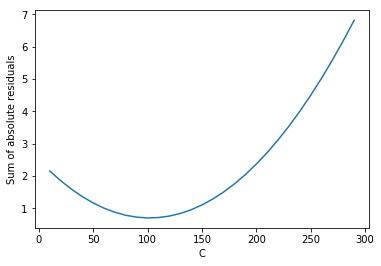

100


In [37]:
# Now we have the data we can easily estimate the hydraulic conductivity from 
# for values of C and use this to find the optimal value of C for each formation

formation = "Permo-Carboniferous"

df_opt = df_coloc_bores[df_coloc_bores['stratigraphy'] == formation]
                 
# Do a linear transform

df_opt['K'] = 10**df_opt['log_K']

# Scan a number of different C values

C_vals = np.arange(10,300, 10)

sum_of_squares = np.nan*np.ones(shape = C_vals.shape)

for i, c in enumerate(C_vals):
    sum_of_squares[i] = objective_function(df_opt, c, 2, equation= 'SDR', loss_fn = 'L2')

# Explore the results

# Find the C that produces the minimum of the residuals

best_C = C_vals[np.argmin(sum_of_squares)]
plt.close()
plt.plot(C_vals,sum_of_squares)
plt.ylabel('Sum of absolute residuals')
plt.xlabel('C')
plt.show()

print(best_C)

ceno_best_c = best_C

In [39]:

objective_function(df_opt, best_C, 2, equation= 'SDR', loss_fn = 'L2')

df_opt

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,borehole_id,log_K,Easting,Northing,Borehole_name,Alternative_name,Ground_elevation_mAHD,Depth_from,Depth_to,Construction_name,stratigraphy,colocated_SNMR_acqu_id,Mobile_water_content,Bound_water_content,Total_water_content,T2*,K,SNMR_K
4,635735,-0.102018,505309.448,8293856.701,RN040878,KR33,16.494,36.0,42.0,screen,Permo-Carboniferous,213,0.081116,0.032200,0.113316,0.102495,0.790646,1.161428
6,635737,0.134896,507769.229,8299897.749,RN040884,KR38,12.462,29.0,35.0,screen,Permo-Carboniferous,217,0.090233,0.013016,0.103248,0.059440,1.364256,0.613706


In [13]:
# Now we have the data we can easily estimate the hydraulic conductivity from 
# for values of C and use this to find the optimal value of C for each formation

formation = "Permo-Carboniferous"

df_opt = df_coloc_bores[df_coloc_bores['stratigraphy'] == formation]
                 

# Do a linear transform

df_opt['K'] = 10**df_opt['log_K']

# Scan a number of different C values

C_vals = np.arange(10,100, 1)

sum_of_squares = np.nan*np.ones(shape = C_vals.shape)

for i, c in enumerate(C_vals):
    sum_of_squares[i] = objective_function(df_opt, c, 2, equation= 'SDR', loss_fn = 'L1')

# Explore the results

# Find the C that produces the minimum of the residuals

best_C = C_vals[np.argmin(sum_of_squares)]
plt.close()
plt.plot(C_vals,sum_of_squares)
plt.ylabel('Sum of absolute residuals')
plt.xlabel('C')
plt.show()

permocarb_C = best_C

NameError: name 'df_coloc_bores' is not defined

In [22]:

objective_function(df_opt, best_C, 2, equation= 'SDR', loss_fn = 'L1')

df_opt


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,borehole_id,log_K,Easting,Northing,Borehole_name,Alternative_name,Ground_elevation_mAHD,Depth_from,Depth_to,Construction_name,stratigraphy,colocated_SNMR_acqu_id,Mobile_water_content,Bound_water_content,Total_water_content,T2*,K,SNMR_K
4,635735,-0.102018,505309.448,8293856.701,RN040878,KR33,16.494,36.0,42.0,screen,Permo-Carboniferous,213,0.081116,0.032200,0.113316,0.102495,0.790646,0.789771
6,635737,0.134896,507769.229,8299897.749,RN040884,KR38,12.462,29.0,35.0,screen,Permo-Carboniferous,217,0.090233,0.013016,0.103248,0.059440,1.364256,0.417320


In [26]:
print(ceno_best_c, permocarb_C)


2050 68
